In [7]:
import cvxpy as cp
cp.__version__

'1.0.24'

# Example       

In [3]:
import cvxpy as cp
import numpy as np

m = 10
n = 5

np.random.seed(1)
A = np.random.randn(m,n)
b = np.random.randn(m)

x = cp.Variable(n)
cost = cp.sum_squares(A*x - b)
objective = cp.Minimize(cost)
constraints = [0 <= x, x <=1]
prob= cp.Problem(objective, constraints)

result = prob.solve()

print("optimal parameter:\n", x.value)
print("Lagrange parameter\n", constraints[0].dual_value)
print("status:"+ prob.status)

optimal parameter:
 [-4.95922264e-21  6.07571976e-21  1.34643668e-01  1.24976681e-01
 -4.57130806e-21]
Lagrange parameter
 [2.00105768 0.75536127 0.         0.         1.17911779]
status:optimal


# Example of CvxOpt

In [2]:
import cvxopt
from cvxopt import matrix
import numpy as np

P = matrix(np.diag([1.0, -1.0]))
q = matrix(np.array([3.0, 4.0]))
A = matrix(np.array([[-1.0, 0.0],[2.0,3.0]]).astype(np.float))
b = matrix(np.array([1.0,1.0]))
G = matrix(np.array([[-2.0, 0.0]]).astype(np.float))
h = matrix(np.array([3.0]))

sol = cvxopt.solvers.qp(P,q, A=A, b=b,G=G, h=h)
print(sol)
print(sol['x'])
print(sol['primal objective'])

     pcost       dcost       gap    pres   dres
 0:  1.0000e+00  8.8818e-16  1e+00  4e-16  8e-01
 1:  1.0000e+00  9.9000e-01  1e-02  8e-17  8e-03
 2:  1.0000e+00  9.9990e-01  1e-04  1e-16  8e-05
 3:  1.0000e+00  1.0000e+00  1e-06  1e-16  8e-07
 4:  1.0000e+00  1.0000e+00  1e-08  7e-17  8e-09
Optimal solution found.
{'x': <2x1 matrix, tc='d'>, 'y': <2x1 matrix, tc='d'>, 's': <1x1 matrix, tc='d'>, 'z': <1x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0000000000000037e-08, 'relative gap': 1.0000000100000038e-08, 'primal objective': 1.0, 'dual objective': 0.99999999, 'primal infeasibility': 7.401486830834377e-17, 'dual infeasibility': 8.000000064507973e-09, 'primal slack': 1.0000000000000002, 'dual slack': 1.0000000000000035e-08, 'iterations': 4}
[-1.00e+00]
[ 1.00e+00]

1.0


# Example
- COst Function: (x - y)^2

In [3]:
import cvxpy as cp

# Create 2 scalar optimization value
x = cp.Variable()
y = cp.Variable()

# Create 2 constrains
constrains = [ (x + y) == 1,
               (x - y) >= 1]

# Form objective(目的関数・コスト関数)
cost = (x- y)**2
obj = cp.Minimize(cost)

# Form and solve problem
prob = cp.Problem(obj, constrains)
prob.solve()

# Result
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal value", x.value, y.value)


status: optimal
optimal value 1.0
optimal value 1.0 1.570086213240983e-22


# Example
- Cost Function: -x1 + x2
- st: (x1 + x2) = 1, (x1 - x2) >= 1

In [4]:
import cvxpy as vp

# Creaate 2 scalar optimization value
x1 = cp.Variable()
x2 = cp.Variable()

# Form objective
cost = -x1+x2
obj = cp.Minimize(cost)

# Create 2 constraints
constraints = [(x1 + x2) == 1,
               (x1 - x2) >= 1]

# Form and solve problem
prob = cp.Problem(obj, constraints)
prob.solve()

# Result
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal value", x.value, y.value)

status: unbounded
optimal value -inf
optimal value 1.0 1.570086213240983e-22


In [5]:
import cvxpy as cp

# Create Variables
x = cp.Variable()
y = cp.Variable()

# Create constraints
constraints = [(x + y) >= 1]

# Cost function
cost = x**2 + y**2
# Form objective
obj = cp.Minimize(cost)

# Form and solve problem
prob = cp.Problem(obj,constraints)
prob.solve()

# Result
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal value", x.value, y.value)


status: optimal
optimal value 0.5000000000000002
optimal value 0.5000000000000001 0.5000000000000001


# Example
- Cost Function: (x1 - 6)^2 + 2 + x2^2

In [1]:
import cvxpy as cp

# Create Variables
x1 = cp.Variable()
x2 = cp.Variable()

# Cost
cost = (x1 - 6)**2 + 2+x2**2
# objective
obj = cp.Minimize(cost)

# Create constraints
constraints = [x1 <= 5,
               -x1<= 5,
               x2 <= 5,
               -x2<= 5]


# Form and solve problem
prob = cp.Problem(obj, constraints)
prob.solve()

# Result
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal value", x1.value, x2.value)


status: optimal
optimal value 3.000000000000001
optimal value 5.0 0.0


# Model predoctive control with cvxpy

# Example
- 倒立振り子を用いた最適制御問題の例
- 初期条件に対する1回分の予測値を算出する
- モデル予測制御は、本処理を処理周期ごとに反復することで、フィードバック系を実現する

In [74]:
import time
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_state = 4   # 状態の数
m_state = 1   # 制御入力の数
T = 100  # 何ステップ先まで予測するかを決める

#simulation parameter
delta_t = 0.01

M = 1.0  # [kg]
m = 0.3  # [kg]
g = 9.8  # [m/s^2]
l = 0.6  # [m]

# Model Parameter
A = np.array([
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, m * g / M, 0.0],
    [0.0, 0.0, 0.0, 1.0],
    [0.0, 0.0, g * (M + m) / (l * M), 0.0]
    ])
A = np.eye(n_state) + delta_t * A
"""
B = np.array([
    [0.0],
    [1.0 / M],
    [0.0],
    [1.0 / (l * M)]
    ])

"""
B = np.array([0.0, 1.0 / M, 0.0, 1.0 / (l * M)])
B = delta_t * B

# 倒立振子の初期状態
# 今回はすべてが0に収束するよう目指す
""" 
# もとの行列だと次元の違いでエラーになる
x0 = np.array([
    [-0.02],
    [0.0],
    [0.02],
    [0.0]
    ])
"""
# 状態変数の初期値を設定
x0 = np.array([-1.0, 0.1, 0.2,0.2])
#x0.shape
print(B.shape)

(4,)


In [85]:
x = cp.Variable((n_state, T+1))
u = cp.Variable((m_state, T))

cost_arr_Q = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.1, 0.0],
    [0.0, 0.0, 0.0, 0.1]
    ])

cost_arr_R = np.array([0.1, 0.1, 0.1, 0.1])

# Init for Clear
cost = 0
constraints = []

for t in range(T):
    # コスト関数の値が小さくなるような配列uを求める
    # sums problem objectives and concatenates constraints.
    cost += cp.sum_squares(cost_arr_Q@x[:,t+1]) + cp.sum_squares( 0.1*u[:,t])
    # 制約式（線形方程式と制御入力の限界値）を与える
    # Push formed problems
    constraints += [x[:,t+1] == A@x[:,t] + B@u[:,t], # 状態方程式の制約
                    cp.norm(u[:,t], 'inf') <= 20.0]  # 入力制限の制約
    
# sums problem objectives and concatenates constraints.
constraints += [x[:,T] == 0, x[:,0] == x0]

# 最適化の目的関数
obj = cp.Minimize(cost)
# Form problem
prob = cp.Problem(obj, constraints)

# 制約をさらに2つ追加する
# 最後の状態(Tステップ後の状態)はすべてが0、すなわち理想の状態とすること
# そして、現在の状態x0は事実としてあるので、制約となる

start = time.time()
result=prob.solve(verbose=False)
elapsed_time = time.time() - start
print("calc time:{0} [sec]".format(elapsed_time))

# 発散した場合は制御不能として終了
if result == float("inf"):
    print("Cannot optimize")
    import sys
    sys.exit()
    
# Result
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal value", u[:,1].value, u[:,10].value)

calc time:1.0162811279296875 [sec]
status: optimal_inaccurate
optimal value 916.301784052545
optimal value [-20.01037148] [-20.00202155]


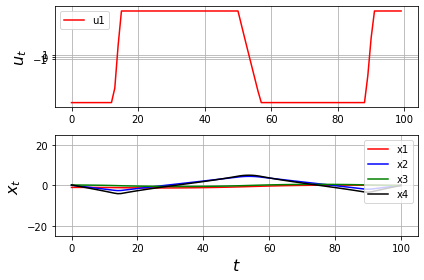

In [102]:
#-1.98240512e-02, 8.64236397e-05, 1.97532638e-02, -5.91928332e-05
f = plt.figure()
ax = f.add_subplot(211)
u1=np.array(u[0,:].value).tolist()
#u2=np.array(u[2].value[0,:])[0].tolist()
plt.plot(u1,'-r',label="u1")
#plt.plot(u2,'-b',label="u2")
plt.ylabel(r"$u_t$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
x1=np.array(x[0,:].value).tolist()
x2=np.array(x[1,:].value).tolist()
x3=np.array(x[2,:].value).tolist()
x4=np.array(x[3,:].value).tolist()

plt.plot(range(T+1), x1,'-r',label="x1")
plt.plot(range(T+1), x2,'-b',label="x2")
plt.plot(range(T+1), x3,'-g',label="x3")
plt.plot(range(T+1), x4,'-k',label="x4")

plt.yticks([-20, 0, 20])
plt.ylim([-25, 25])
plt.ylabel(r"$x_t$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
x[1,:].value.reshape(1,101).shape

(1, 101)

In [71]:
np.array(x[0,:].value)[0].tolist()

-0.019824051242043818

In [101]:
u1=np.array(u[:].value[0]).tolist()
np.array(u[:].value[0])
u.shape

(1, 100)

In [86]:
u[:,0].value

array([-20.01165038])

# Basic Example of the Control problem

In [4]:
# Form and solve control problem.
import cvxpy as cp

# Generate data for control problem.
import numpy as np
np.random.seed(1)
n = 8
m = 2
T = 50
alpha = 0.2
beta = 5
A = np.eye(n) + alpha*np.random.randn(n,n)
B = np.random.randn(n,m)
x_0 = beta*np.random.randn(n)

x = cp.Variable((n, T+1))
u = cp.Variable((m, T))

cost = 0
constr = []
for t in range(T):
    cost += cp.sum_squares(x[:,t+1]) + cp.sum_squares(u[:,t])
    constr += [x[:,t+1] == A@x[:,t] + B@u[:,t],
               cp.norm(u[:,t], 'inf') <= 1]
# sums problem objectives and concatenates constraints.
constr += [x[:,T] == 0, x[:,0] == x_0]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(solver=cp.ECOS)

64470.57722638684